In [93]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import glob
import os
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}
results_dir = '../data/results/campylobacterota'

test_genome_ids = pd.read_csv('../data/campylobacterota_dataset_test.csv', index_col=0).genome_id.unique()
train_genome_ids = pd.read_csv('../data/campylobacterota_dataset_train.csv', index_col=0).genome_id.unique()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
model_name = 'campylobacterota_esm_650m_gap_v201'

test_results = Results(test_genome_ids, load_ref=True, load_labels=True)
train_results = Results(train_genome_ids, load_ref=True, load_labels=True)

test_results.load_predict(f'{results_dir}/campylobacterota_dataset_test_predict.csv', model_name=model_name)
train_results.load_predict(f'{results_dir}/campylobacterota_dataset_train_predict.csv', model_name=model_name)

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)

In [89]:
results = Results.concat(train_results, test_results)

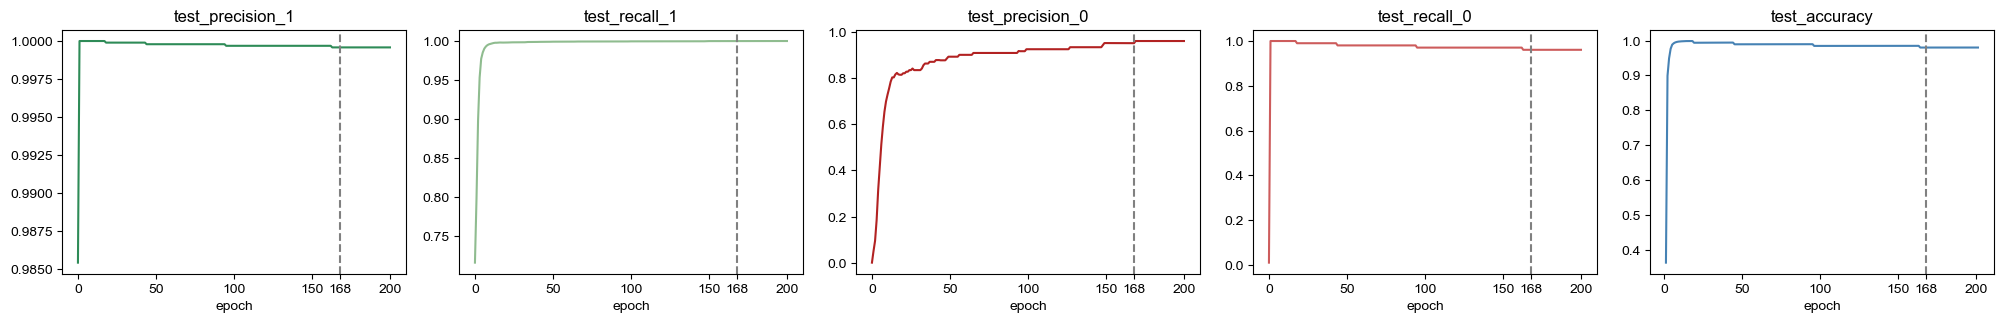

In [47]:
model = Classifier.load('../models/campylobacterota_esm_650m_gap_v202.pkl')

def figure_1(model:Classifier, path:str=None, metrics:list=['test_precision_1', 'test_recall_1', 'test_precision_0', 'test_recall_0', 'test_accuracy']):
    
    colors = dict()
    colors['test_precision_1'] = 'seagreen'
    colors['test_recall_1'] = 'darkseagreen'
    colors['test_precision_0'] = 'firebrick'
    colors['test_recall_0'] = 'indianred'
    colors['test_accuracy'] = 'steelblue'

    fig, axes = plt.subplots(ncols=len(metrics), figsize=(4 * len(metrics), 3))
    fig.tight_layout()
    
    for ax, metric in zip(axes, metrics):
        ax.set_title(metric)
        ax = sns.lineplot(x=np.arange(len(model.metrics[metric])), y=model.metrics[metric], label=metric, color=colors[metric], ax=ax, legend=False)
        ax.axvline(x=model.best_epoch, color='gray', linestyle='--')

        xticks = sorted(list(range(0, model.epochs + 1, 50)) + [model.best_epoch])
        ax.set_xticks(xticks, labels=xticks)
        ax.set_xlabel('epoch')
    
    plt.show()

figure_1(model)

In [ ]:

def table_1(path:str='../data/figures/results-campylobacterota-table_1.png'):

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*')]

    results = Results(test_genome_ids, load_ref=True, load_labels=True)
    results.load_predict(f'{results_dir}/campylobacterota_dataset_test_predict.csv', model_name=None)
    df = results.to_df()
    df = df.dropna()
    df['label'] = [0 if (label == 'spurious') else 1 for label in df.label]
    
    table_df = list()
    for model_name in model_names:
        row = dict()
        row['feature type'] = re.search('(esm_650m_gap|pt5_3b_gap|esm_3b_gap)', model_name).group(1) 
        row['model_name'] = model_name
        row.update(df[f'{model_name}_confusion_matrix'].replace(confusion_matrix_map).value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(df.label, df[f'{model_name}_label']), 4)
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false positive')

    dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df

table_1()


,feature type,true positive,true negative,false negative,false positive,accuracy
model_name,,,,,,
campylobacterota_esm_650m_gap_v201,esm_650m_gap,12554,56,2,1,0.9911
campylobacterota_esm_650m_gap_v202,esm_650m_gap,12531,56,25,1,0.9902
campylobacterota_esm_650m_gap_v101,esm_650m_gap,12550,56,6,1,0.9910
campylobacterota_esm_650m_gap_v301,esm_650m_gap,12550,55,6,2,0.9822


In [ ]:
def figure_2(results):

    pass 

In [91]:
results.to_df().value_counts('genome_id')

genome_id
GCF_000183725.1    1782
GCF_016937535.1    1482
GCF_900637325.1    1452
GCF_000242915.1    1310
GCF_003546685.2    1214
                   ... 
GCF_002139935.1     138
GCF_000162575.1     129
GCF_900197775.1     118
GCF_003355515.1     108
GCF_013372245.1      78
Name: count, Length: 196, dtype: int64

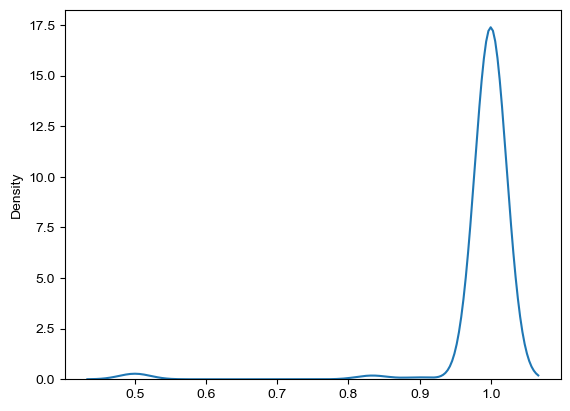

In [ ]:
# Want to get a rough estimate of the performance per genome. There are 40 genomes in the test dataset. 
# How does it correlate with genome characteristics?
def figure_3(results:Results, genome_metadata_df:pd.DataFrame):
    df = results.to_df()
    df = df.merge(genome_metadata_df, right_index=True, left_on='genome_id', validate='many_to_one')
    df['label'] = [0 if (label == 'spurious') else 1 for label in df.label]

    fig = plt.figure()
    ax = fig.add_subplot()

    ax_df = pd.DataFrame(index=df.groupby('genome_id').genome_id)
    ax_df = ax_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label))
    sns.kdeplot(data=ax_df, ax=ax)

figure_3(results, genome_metadata_df)